In [2]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Submission & Comments Count Statistics
------

In [3]:
base_dir = '../posts_categorization/linked_submissions_comments'
save_dir = '../posts_categorization/concatenated_linked_datasets'
os.makedirs(save_dir, exist_ok=True)

In [4]:
suicide_dfs = []
depression_dfs = []

for filename in tqdm(os.listdir(base_dir), desc='Processing files'):
    if filename.endswith(".csv"):
        filepath = os.path.join(base_dir, filename)
        if "suicide" in filename:
            suicide_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        elif "depression" in filename:
            depression_dfs.append(pd.read_csv(filepath, dtype=str, encoding='utf-8', lineterminator='\n'))
        else:
            print("Error: Non-relevant datasets.")

concatenated_suicide_linked = pd.concat(tqdm(suicide_dfs, desc="Concatenating suicide data"), ignore_index=True)
concatenated_depression_linked = pd.concat(tqdm(depression_dfs, desc="Concatenating depression data"), ignore_index=True)

concatenated_suicide_linked = concatenated_suicide_linked.drop(concatenated_suicide_linked.columns[0], axis=1)
concatenated_depression_linked = concatenated_depression_linked.drop(concatenated_depression_linked.columns[0], axis=1)

linked_suicide_save_path = os.path.join(save_dir, "concatenated_suicide_linked.csv")
linked_depression_save_path = os.path.join(save_dir, "concatenated_depression_linked.csv")

concatenated_suicide_linked.to_csv(linked_suicide_save_path, index=False)
concatenated_depression_linked.to_csv(linked_depression_save_path, index=False)

Concatenating depression data: 100%|██████████| 4/4 [00:00<00:00, 88768.34it/s]


In [5]:
def analyze_submission_comment_distribution(dataframe):
    unique_submissions = dataframe[['submitter_username', 'content_submission', 'thread_id']].drop_duplicates()
    total_submissions = unique_submissions.shape[0]

    unique_comments = dataframe[['commenter_username', 'content_comment', 'thread_id']]
    total_comments = unique_comments.shape[0]

    submission_counts = unique_submissions.groupby('thread_id').size().reset_index(name='submission_count')

    comment_counts = unique_comments.groupby('thread_id').size().reset_index(name='comment_count')

    merged_counts = pd.merge(submission_counts, comment_counts, on='thread_id', how='left').fillna(0)

    plt.figure(figsize=(10, 6))
    plt.hist(merged_counts['comment_count'], bins=range(0, merged_counts['comment_count'].max() + 1), edgecolor='black')
    plt.title('Distribution of Comments per Submission')
    plt.xlabel('Number of Comments')
    plt.ylabel('Number of Submissions')
    plt.show()

    print(f"Total number of submissions: {total_submissions}")
    print(f"Total number of comments: {total_comments}")

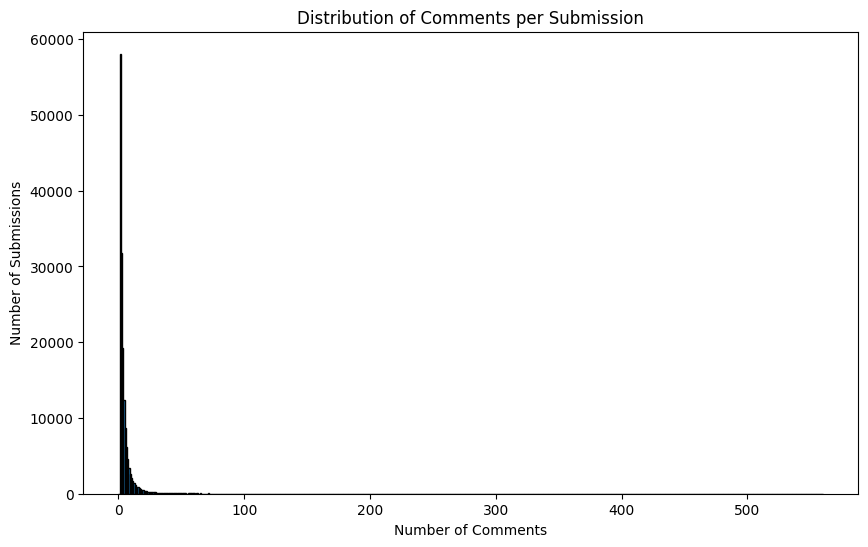

Total number of submissions: 163054
Total number of comments: 770413


In [6]:
analyze_submission_comment_distribution(concatenated_suicide_linked)

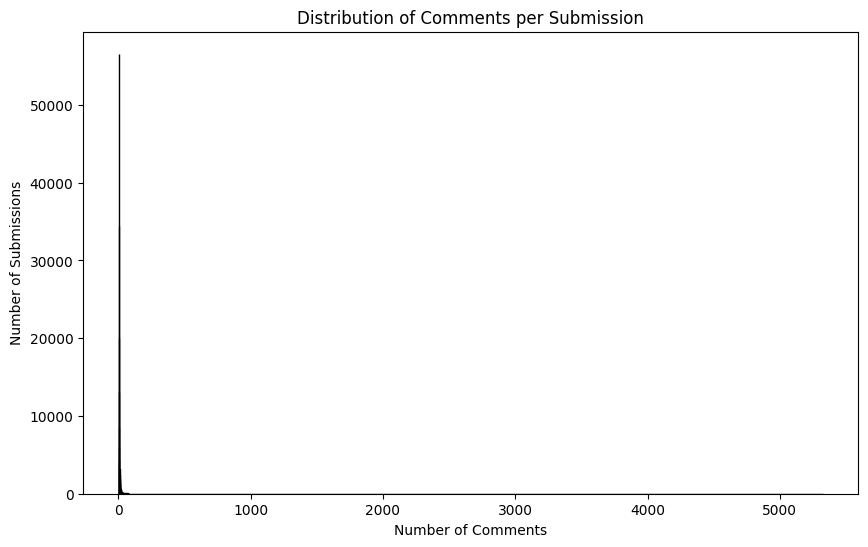

Total number of submissions: 164202
Total number of comments: 846061


In [7]:
analyze_submission_comment_distribution(concatenated_depression_linked)

In [73]:
def generate_category_statistics(year, subreddit_name, type, categ_methods=['llama', 'gemma', 'qwen']):
    if type == 'submissions':
        if year == 2020 or year == 2022 or year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
            original_df = original_df[~original_df[['submitter_username', 'content_submission', 'thread_id']].duplicated()]
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'submissions_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['submissions_category', f'{categ_method}_submissions_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='submissions_category', how='outer')

        categ_stats_merged['mean_submissions_count'] = categ_stats_merged[[f'{categ_method}_submissions_count' for categ_method in categ_methods]].mean(axis=1).round(2)


    elif type == 'comments':
        if year == 2020 or year == 2022 or year == 2023 or year == 2024:
            original_df = pd.read_csv(f'linked_submissions_comments/{year}_{subreddit_name}_linked_llama_gemma_qwen.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        elif year == 'all':
            original_df = pd.read_csv(f'concatenated_linked_datasets/concatenated_{subreddit_name}_linked.csv', dtype=str, encoding='utf-8', lineterminator='\n')
        else:
            print("Invalid year.")
            return None

        categ_stats_list = []

        for categ_method in categ_methods:
            value_counts = original_df[f'comments_categ_{categ_method}'].value_counts()

            value_counts_df = value_counts.reset_index()
            value_counts_df.columns = ['comments_category', f'{categ_method}_comments_count']

            categ_stats_list.append(value_counts_df)

        categ_stats_merged = categ_stats_list[0]
        for df in categ_stats_list[1:]:
            categ_stats_merged = pd.merge(categ_stats_merged, df, on='comments_category', how='outer')

        categ_stats_merged['mean_comments_count'] = categ_stats_merged[[f'{categ_method}_comments_count' for categ_method in categ_methods]].mean(axis=1).round(2)


    print(categ_stats_merged)

In [74]:
generate_category_statistics('all', 'suicide', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                   118746                   142483   
1                    2                    28978                    16938   
2                    3                     2088                      486   
3                    4                    13242                     3147   

   qwen_submissions_count  mean_submissions_count  
0                  134336               131855.00  
1                   15444                20453.33  
2                    2225                 1599.67  
3                   11049                 9146.00  


In [75]:
generate_category_statistics('all', 'depression', 'submissions')

  submissions_category  llama_submissions_count  gemma_submissions_count  \
0                    1                   115397                   129173   
1                    2                    42630                    32895   
2                    3                     2385                      841   
3                    4                     3790                     1293   

   qwen_submissions_count  mean_submissions_count  
0                  128751               124440.33  
1                   27350                34291.67  
2                    3603                 2276.33  
3                    4498                 3193.67  


In [76]:
generate_category_statistics('all', 'suicide', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                292100                423402   
1                 2                306036                111528   
2                 3                 76724                 60526   
3                 4                 95553                174957   

   qwen_comments_count  mean_comments_count  
0               321779            345760.33  
1               180463            199342.33  
2                60823             66024.33  
3               207348            159286.00  


In [77]:
generate_category_statistics('all', 'depression', 'comments')

  comments_category  llama_comments_count  gemma_comments_count  \
0                 1                312120                438922   
1                 2                333782                138079   
2                 3                118689                116853   
3                 4                 81470                152207   

   qwen_comments_count  mean_comments_count  
0               341937            364326.33  
1               226829            232896.67  
2               102696            112746.00  
3               174599            136092.00  


In [66]:
years = [2020, 2022, 2023, 2024, 'all']
subreddit_names = ['suicide', 'depression']
types = ['submissions', 'comments']

for year in years:
    for subreddit_name in subreddit_names:
        for type in types:
            generate_category_statistics('all', 'depression', 'submissions')